<a href="https://colab.research.google.com/github/sreedevigattu/wids2021/blob/main/Lab_apachecov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/widsdatathon2021.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

###Data Viz

In [2]:
df=pd.read_csv('/content/drive/MyDrive/TrainingWiDS2021.csv',index_col=0)

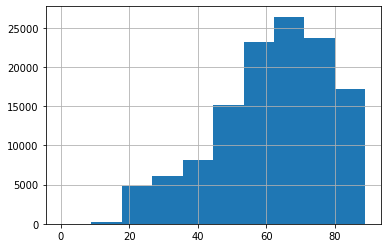

In [29]:
df['age'].hist(bins=10)

In [30]:
ddic=pd.read_csv('/content/drive/MyDrive/DataDictionaryWiDS2021.csv')

In [31]:
ddic['Category'].unique()

array(['identifier', 'demographic', 'APACHE covariate', 'vitals', 'labs',
       'labs blood gas', 'APACHE comorbidity', 'Target Variable'],
      dtype=object)

## Labs

In [32]:
labs=ddic.index[(ddic['Category']=='labs')]

In [ ]:
df.iloc[:,labs-1].isnull().sum()/df.shape[0]*100
#Labs all h1 except glucose can be deleted


d1_albumin_max       54.861437
d1_albumin_min       54.861437
d1_bilirubin_max     58.955723
d1_bilirubin_min     58.955723
d1_bun_max           10.551872
d1_bun_min           10.551872
d1_calcium_max       12.824512
d1_calcium_min       12.824512
d1_creatinine_max    10.197684
d1_creatinine_min    10.197684
d1_glucose_max        6.333121
d1_glucose_min        6.333121
d1_hco3_max          15.402168
d1_hco3_min          15.402168
d1_hemaglobin_max    12.471093
d1_hemaglobin_min    12.471093
d1_hematocrit_max    11.976306
d1_hematocrit_min    11.976306
d1_inr_max           62.396183
d1_inr_min           62.396183
d1_lactate_max       73.375231
d1_lactate_min       73.375231
d1_platelets_max     14.257397
d1_platelets_min     14.257397
d1_potassium_max      9.639128
d1_potassium_min      9.639128
d1_sodium_max        10.195379
d1_sodium_min        10.195379
d1_wbc_max           13.390751
d1_wbc_min           13.390751
h1_albumin_max       91.431886
h1_albumin_min       91.431886
h1_bilir

Labs pipeline:

1. Drop all of the h1 variables- Except h1_glucose_max and h1_glucose_min

2. Drop all of the d1_{something}_min variable, we can rely on the **max** variables

3. For h1_glucose_max and h1_glucose_min, we can create a single variable: h1_glucose_average or we can choose to look into one (preferably max)
4. Impute missing values with their corresponding median value, For **Hemoglobin and Hematocrit** based on gender impute median
5. For WBC impute with mean

Final Labs variables are all of the d1_{ }_max columns + h1_glucose_average/max 
= 15 + 1= 16 features
We can also include the d1_glucose_min if needed(Have to iterate)



In [36]:
df.iloc[:,labs-1].describe() # take the maxi columns d1 for labs

,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min
count,58751.000000,58751.000000,53422.000000,53422.000000,116423.000000,116423.000000,113465.000000,113465.000000,116884.000000,116884.000000,121914.000000,121914.000000,110110.000000,110110.000000,113925.000000,113925.000000,114569.000000,114569.000000,48944.000000,48944.000000,34654.000000,34654.000000,111600.000000,111600.000000,117611.000000,117611.000000,116887.000000,116887.000000,112728.000000,112728.000000,11152.000000,11152.000000,10296.000000,10296.000000,25167.000000,25167.000000,24236.000000,24236.000000,25373.000000,25373.000000,55084.000000,55084.000000,23762.000000,23762.000000,27367.000000,27367.000000,27201.000000,27201.000000,48944.000000,48944.000000,11690.000000,11690.000000,24428.000000,24428.000000,29336.000000,29336.000000,28376.000000,28376.000000,24171.000000,24171.000000
mean,2.952673,2.883073,1.191379,1.117405,25.578808,23.554154,8.379782,8.164674,1.493531,1.363795,174.149802,114.440310,24.452872,23.192344,11.459810,10.901491,34.555834,32.939299,1.577788,1.463473,2.922075,2.078145,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,3.008563,3.007254,1.187979,1.187173,25.631220,25.606374,8.274175,8.265049,1.526582,1.524339,167.702625,158.908794,22.544112,22.486146,11.204166,11.088205,33.731830,33.349796,1.577788,1.463473,3.028198,2.976982,193.943057,193.123506,4.188984,4.147028,138.167205,137.879814,13.387873,13.336485
std,0.675606,0.679808,2.319165,2.201525,20.495927,18.708332,0.740098,0.793055,1.525906,1.341642,86.545466,38.217682,4.364990,5.000293,2.149213,2.338048,6.194616,6.806350,0.946477,0.737639,3.057443,2.064291,89.547477,88.121757,0.666942,0.579459,4.827752,4.926242,6.782836,5.924633,0.738170,0.738457,2.375772,2.375223,21.377589,21.360676,0.892787,0.905489,1.572771,1.570070,94.033461,88.298827,5.138495,5.144693,2.350633,2.381224,6.804903,6.963975,0.946477,0.737639,2.898524,2.854953,92.486473,92.692759,0.760183,0.749463,5.711628,5.658036,6.933161,6.915142
min,1.200000,1.100000,0.200000,0.200000,4.000000,3.000000,6.200000,5.500000,0.340000,0.300000,73.000000,33.000000,12.000000,7.000000,6.800000,5.300000,20.400000,16.100000,0.900000,0.900000,0.400000,0.400000,27.000000,18.550000,2.800000,2.400000,123.000000,117.000000,1.200000,0.900000,1.100000,1.100000,0.200000,0.200000,4.000000,4.000000,5.600000,5.300000,0.330000,0.330000,59.000000,42.000000,6.000000,6.000000,5.100000,5.000000,16.000000,15.500000,0.900000,0.900000,0.400000,0.400000,20.000000,20.000000,2.500000,2.500000,114.000000,114.000000,1.100000,1.089800
25%,2.500000,2.400000,0.400000,0.400000,13.000000,12.000000,7.900000,7.700000,0.750000,0.710000,117.000000,91.000000,22.000000,21.000000,9.900000,9.200000,30.000000,28.000000,1.100000,1.100000,1.200000,1.000000,147.000000,136.000000,3.800000,3.600000,137.000000,135.000000,8.000000,7.400000,2.500000,2.500000,0.400000,0.400000,13.000000,13.000000,7.700000,7.700000,0.780000,0.780000,111.000000,106.000000,20.000000,20.000000,9.600000,9.400000,29.000000,28.400000,1.100000,1.100000,1.300000,1.250000,131.000000,130.000000,3.700000,3.700000,136.000000,135.000000,8.600000,8.500000
50%,3.

## APACHE Covariates

In [34]:
apachecov=ddic.index[(ddic['Category']=='APACHE covariate')]

In [35]:
df.iloc[:,apachecov-1].isnull().sum()/df.shape[0]*100
#labs blood gas can be fully dropped information is present in apache cov

albumin_apache           60.052859
apache_2_diagnosis        1.294590
apache_3j_diagnosis       0.664582
apache_post_operative     0.000000
arf_apache                0.000000
bilirubin_apache         63.431087
bun_apache               19.523345
creatinine_apache        19.116913
fio2_apache              76.615165
gcs_eyes_apache           1.682583
gcs_motor_apache          1.682583
gcs_unable_apache         0.544727
gcs_verbal_apache         1.682583
glucose_apache           11.290979
heart_rate_apache         0.237406
hematocrit_apache        20.558249
intubated_apache          0.000000
map_apache                0.322687
paco2_apache             76.615165
paco2_for_ph_apache      76.615165
pao2_apache              76.615165
ph_apache                76.615165
resprate_apache           0.620789
sodium_apache            18.838019
temp_apache               5.079250
urineoutput_apache       48.531389
ventilated_apache         0.000000
wbc_apache               22.645728
dtype: float64

In [37]:
df.iloc[:,apachecov-1].describe() 

,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache
count,51994.000000,128472.000000,129292.000000,130157.000000,130157.000000,47597.000000,104746.000000,105275.000000,30437.000000,127967.000000,127967.000000,129448.000000,127967.000000,115461.000000,129848.000000,103399.000000,130157.000000,129737.000000,30437.000000,30437.000000,30437.000000,30437.000000,129349.000000,105638.00000,123546.000000,66990.000000,130157.000000,100682.000000
mean,2.886149,185.492683,565.994296,0.207111,0.027997,1.201222,25.718070,1.481629,0.595735,3.488290,5.484828,0.011441,4.030203,160.141416,99.854530,32.975817,0.156626,87.193046,42.161246,42.161246,132.061737,7.352154,25.150603,137.94526,36.420638,1800.803417,0.330432,12.187662
std,0.689812,85.858208,466.510850,0.405238,0.164965,2.351994,20.690041,1.543535,0.262922,0.939831,1.271039,0.106349,1.538528,90.701327,30.759505,6.834576,0.363449,41.908109,12.267414,12.267414,84.958826,0.098423,15.024730,5.30384,0.857584,1456.551481,0.470370,6.931023
min,1.200000,101.000000,0.010000,0.000000,0.000000,0.100000,4.000000,0.300000,0.210000,1.000000,1.000000,0.000000,1.000000,39.000000,30.000000,16.200000,0.000000,40.000000,18.000000,18.000000,31.000000,6.960540,4.000000,117.00000,32.100000,0.000000,0.000000,0.900000
25%,2.400000,113.000000,204.010000,0.000000,0.000000,0.400000,13.000000,0.710000,0.400000,3.000000,6.000000,0.000000,4.000000,97.000000,87.000000,28.000000,0.000000,54.000000,34.500000,34.500000,77.000000,7.301000,11.000000,135.00000,36.200000,799.048800,0.000000,7.500000
50%,2.900000,122.000000,409.020000,0.000000,0.000000,0.700000,19.000000,0.970000,0.500000,4.000000,6.000000,0.000000,5.000000,133.000000,104.000000,33.100000,0.000000,66.000000,40.000000,40.000000,104.000000,7.360000,27.000000,138.00000,36.500000,1454.976000,0.000000,10.470000
75%,3.400000,301.000000,703.030000,0.000000,0.000000,1.100000,31.000000,1.530000,0.850000,4.000000,6.000000,0.000000,5.000000,195.000000,120.000000,37.900000,0.000000,124.000000,47.000000,47.000000,156.000000,7.414000,36.000000,141.00000,36.700000,2415.096000,1.000000,15.300000
max,4.600000,308.000000,2201.050000,1.000000,1.000000,60.200000,127.000000,11.180000,1.000000,4.000000,6.000000,1.000000,5.000000,598.700000,178.000000,51.400000,1.000000,200.000000,95.000000,95.000000,498.000000,7.590000,60.000000,158.00000,39.700000,8716.669632,1.000000,45.800000


For now, we can choose to have 3 approaches with APACHE Covariates

1. Include none: have an ML pipeline with none from this category
2. Include essential: apache_2_diagnosis, apache_3j_diagnosis, intubated_apache, urineoutput_apache, ventilated_apache
3. Include essential + those dropped from labs blood gas:
Approach 2 features  +
paco2_apache,	paco2_for_ph_apache,	pao2_apache,	ph_apache- But will need median imputation since there are a lot of missing values
4. Include all variables

**In my opinion we can either try Approach one or two now for the pipeline**

##Labs blood gas

In [38]:
labsbg=ddic.index[(ddic['Category']=='labs blood gas')]

In [ ]:
df.iloc[:,labsbg-1].isnull().sum()/df.shape[0]*100
#LABS BG MORE than 60% missing

d1_arterial_pco2_max    64.891631
d1_arterial_pco2_min    64.891631
d1_arterial_ph_max      65.157464
d1_arterial_ph_min      65.157464
d1_arterial_po2_max     64.545126
d1_arterial_po2_min     64.545126
d1_pao2fio2ratio_max    71.712624
d1_pao2fio2ratio_min    71.712624
h1_arterial_pco2_max    82.720100
h1_arterial_pco2_min    82.720100
h1_arterial_ph_max      82.860699
h1_arterial_ph_min      82.860699
h1_arterial_po2_max     82.550305
h1_arterial_po2_min     82.550305
h1_pao2fio2ratio_max    87.123243
h1_pao2fio2ratio_min    87.123243
dtype: float64

Enough information is present in the APACHE covariates, if needed after the pipeline we can impute the apache covariates using the D1 variables in this category, however now we can choose to ignore all of these features in the labs blood gas category

##Rough category